In [2]:
import pandas as pd  # For manipulating data structures
import numpy as np  # For mathematical functions
import scipy.stats as stats  # Algorithms and convenience functions built on NumPy
import statsmodels.api as sm  # For statistical methods
import statsmodels.formula.api as smf  # For writing formulas
import patsy
import matplotlib.pyplot as plt  # Essentially the Python equivalent to ggplot2
import seaborn as sns  # A library for statistical graphics built on Matplotlib

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    rc=custom_params,
)

scavengers = pd.read_csv("../data/cleaned scavenger data.csv", index_col="Species name")

scavengers.drop(
    ["BirdLife Extent of occurrence"], axis=1, inplace=True
)

Text(0.02, 0.5, 'Number of species')

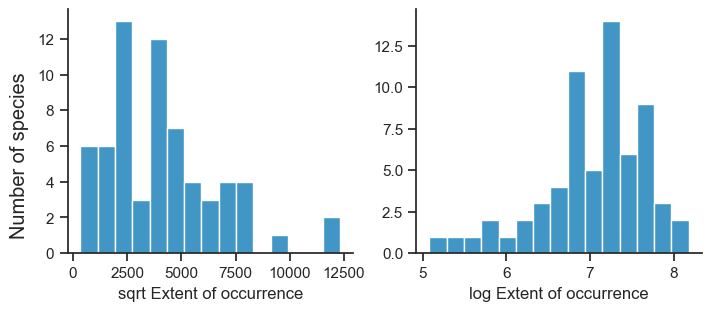

In [3]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(7,3), layout="constrained")

sns.histplot(
    ax=ax1,
    data=scavengers,
    x=np.sqrt(scavengers["Extent of occurrence"]),
    bins=15,
)
sns.histplot(
    ax=ax2,
    data=scavengers,
    x="log Extent of occurrence",
    bins=15
)
ax1.set_xlabel("sqrt Extent of occurrence")
ax1.set_ylabel("")
ax2.set_ylabel("")
fig.supylabel("Number of species")

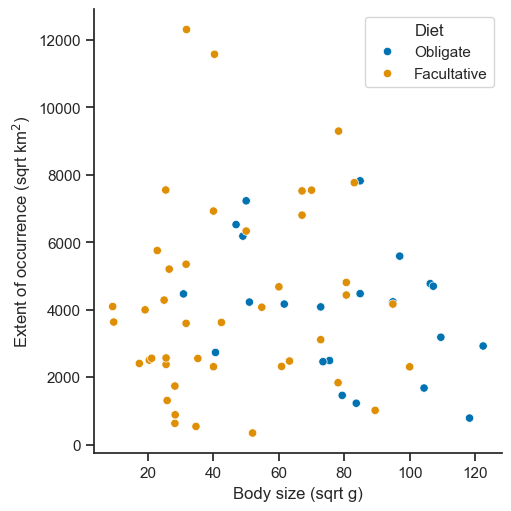

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5,5), layout="constrained")

sns.scatterplot(
    data=scavengers,
    x=np.sqrt(scavengers["Body size"]),
    y=np.sqrt(scavengers["Extent of occurrence"]),
    hue="Diet",
)
ax.set_ylabel("Extent of occurrence (sqrt km$^2$)")
ax.set_xlabel("Body size (sqrt g)")
plt.show()

Check whether the log-transformed data have the skewness and kurtosis of a normal distribution.

The Raw Data Jarque-Bera test statistic below concurs with the above histograms that our data distribution is not normally distributed when examining all scavengers as a single group, but are normally distributed when log-transformed.

Note that I should only take this test with a grain of salt, because the sample size is much smaller than what is advised (>2000).

In [5]:
body_jb_test = stats.jarque_bera(x=(scavengers["log Body size"]))

eoo_jb_test = stats.jarque_bera(x=scavengers["log Extent of occurrence"])

print(f"log body size Jarque-Bera Test:\nStatistic: {body_jb_test.statistic:.2f}, p-value: {body_jb_test.pvalue:.5f}")

print(f"log EOO Jarque-Bera Test:\nStatistic: {eoo_jb_test.statistic:.2f}, p-value: {eoo_jb_test.pvalue:.5f}")

log body size Jarque-Bera Test:
Statistic: 4.07, p-value: 0.13076
log EOO Jarque-Bera Test:
Statistic: 9.46, p-value: 0.00884


Check whether the log-transformed data have the skewness and kurtosis of a normal distribution. I selected the Shapiro-Wilk test because it is better suited for small sample sizes than something like the Jarque-Bera test, which is better suited for >2000 samples for the `jarque-bera` test from Statsmodels.

In [6]:
body_shapiro = stats.shapiro(x=(scavengers["log Body size"]))

eoo_shapiro = stats.shapiro(x=scavengers["log Extent of occurrence"])

print(f"log body size Shapiro-Wilk test:\nStatistic: {body_shapiro.statistic:.2f}, p-value: {body_shapiro.pvalue:.5f}")

print(f"log EOO Shapiro-Wilk test:\nStatistic: {eoo_shapiro.statistic:.2f}, p-value: {eoo_shapiro.pvalue:.5f}")

log body size Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00675
log EOO Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00790


# Global avian scavengers

In [7]:
# Define the X and Y matrices
y = scavengers["Extent of occurrence"]
x = scavengers["Body size"]
log_y = scavengers["log Extent of occurrence"]
log_x = scavengers["log Body size"]

# Add a column called "const" to the design matrix, X
x = sm.add_constant(x)
log_x = sm.add_constant(log_x)
x.head()

ols_model = sm.OLS(y, x).fit()
log_ols_model=sm.OLS(log_y, log_x).fit()

Text(0, 0.5, 'Extent of occurrence km$^2$')

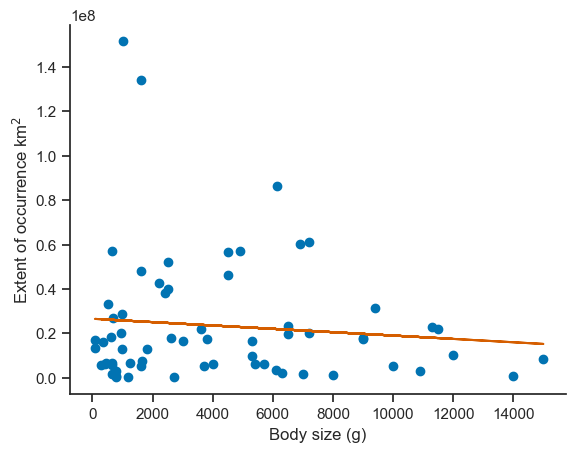

In [8]:
# LineEquation = 6.9554 + 0.0261 * x
LineEquation = 2.657e+07 + (-756.5066 * x)

plt.scatter(
    x="Body size",
    y="Extent of occurrence",
    data=scavengers
)
plt.plot(x, LineEquation, color="r",)
plt.xlabel("Body size (g)")
plt.ylabel("Extent of occurrence km$^2$")

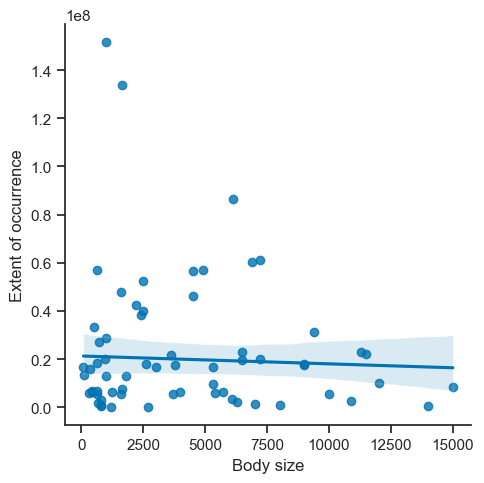

In [9]:
sns.lmplot(
    x="Body size",
    y="Extent of occurrence",
    data=scavengers,
    scatter=True,
    robust=True,
)

In [10]:
ols_fitted = ols_model.fittedvalues
ols_residuals = ols_model.resid
log_ols_residuals = log_ols_model.resid
# Note: the 50th percentile is the same as the median

print(ols_residuals.describe())
print(log_ols_residuals.describe())

count    6.500000e+01
mean     4.584973e-10
std      2.856703e+07
min     -2.557115e+07
25%     -1.857916e+07
50%     -7.685494e+06
75%      4.781587e+06
max      1.257176e+08
dtype: float64
count    6.500000e+01
mean     1.325435e-15
std      6.354159e-01
min     -1.963329e+00
25%     -2.701634e-01
50%      1.744652e-01
75%      4.232809e-01
max      1.146722e+00
dtype: float64


<Axes: >

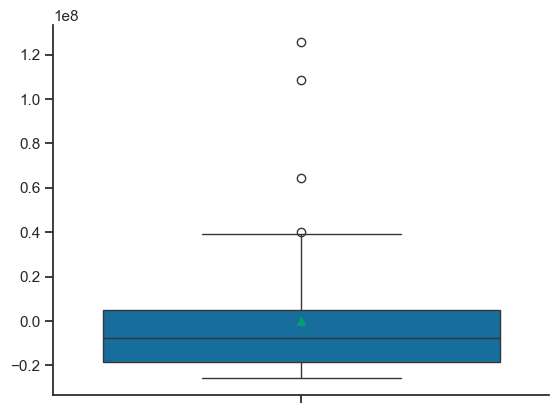

In [11]:
sns.boxplot(ols_residuals, showmeans=True)

Shapiro-Wilk test for normality

In [12]:
ols_shapiro = stats.shapiro(ols_residuals)

print(
    f"OLS residuals Shapiro-Wilk test:\n"
    f"Statistic: {ols_shapiro.statistic:.2f}, p-value: {ols_shapiro.pvalue:.5f}"
)

OLS residuals Shapiro-Wilk test:
Statistic: 0.74, p-value: 0.00000


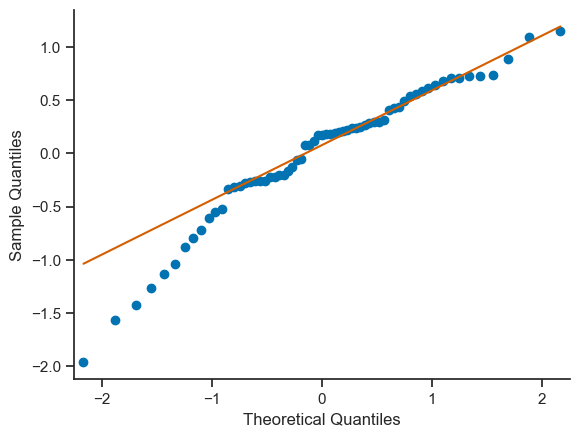

In [13]:
# Include a line fit through the quartiles. This makes the function behave the same as in R.
sm.qqplot(log_ols_residuals, line="q")
plt.show()

In [14]:
ols_model.outlier_test()

,student_resid,unadj_p,bonf(p)
Black vulture,0.617252,0.539329,1.0
Turkey vulture,0.967120,0.337241,1.0
Lesser yellow headed vulture,-0.204881,0.838337,1.0
Greater yellow headed vulture,-0.623685,0.535123,1.0
King vulture,-0.219151,0.827252,1.0
...,...,...,...
Canada jay,-0.341154,0.734141,1.0
Siberian jay,-0.466034,0.642824,1.0
Chihuahua raven,-0.856261,0.395151,1.0
Torresian crow,-0.683161,0.497050,1.0


In [15]:
outlier_test_results = ols_model.outlier_test()

# Identify observations with high studentized residuals (e.g., beyond ±2)
high_residuals = outlier_test_results[abs(outlier_test_results['student_resid']) > 2]

# Print the observations with high studentized residuals
print("Observations with high studentized residuals:")
print(high_residuals)

Observations with high studentized residuals:
              student_resid   unadj_p   bonf(p)
Common raven       4.317678  0.000058  0.003762
Golden eagle       2.341806  0.022418  1.000000
Black kite         5.286957  0.000002  0.000111


In [16]:
# Examine the specific observations in the scavengers dataset
high_residuals_observations = scavengers.loc[high_residuals.index]

print("Details of observations with high studentized residuals:")
print(high_residuals_observations)

Details of observations with high studentized residuals:
                Scientific name         Diet  Extent of occurrence  Body size  \
Common raven       Corvus corax  Facultative          1.339887e+08       1625   
Golden eagle  Aquila chrysaetos  Facultative          8.645233e+07       6125   
Black kite       Milvus migrans  Facultative          1.515286e+08       1008   

              log Extent of occurrence  log Body size  
Common raven                  8.127068       3.210853  
Golden eagle                  7.936777       3.787106  
Black kite                    8.180495       3.003461  


<Axes: >

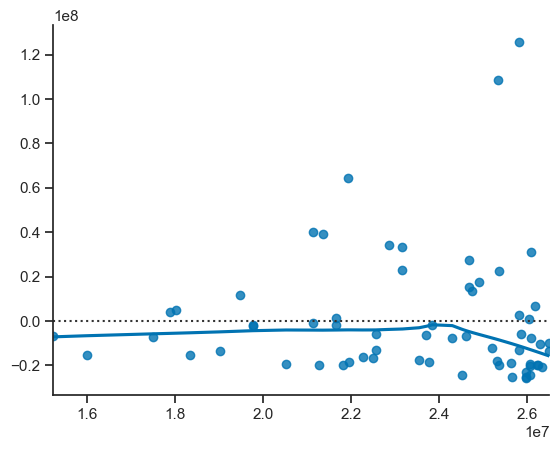

In [17]:
sns.residplot(x=ols_fitted, y=ols_residuals, lowess=True)

In [19]:
# sm.graphics.plot_regress_exog(results=ols_model, exog_idx="log Body size")
# fig.tight_layout(pad=1.0)

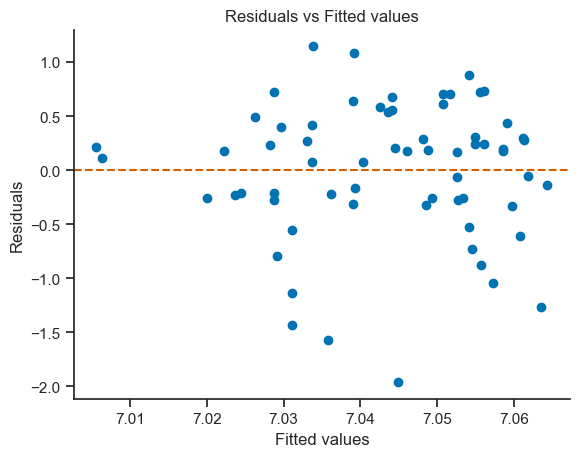

In [ ]:
plt.scatter(ols_fitted, ols_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted values")
plt.show()

Text(0, 0.5, 'log EOO (km$^2$)')

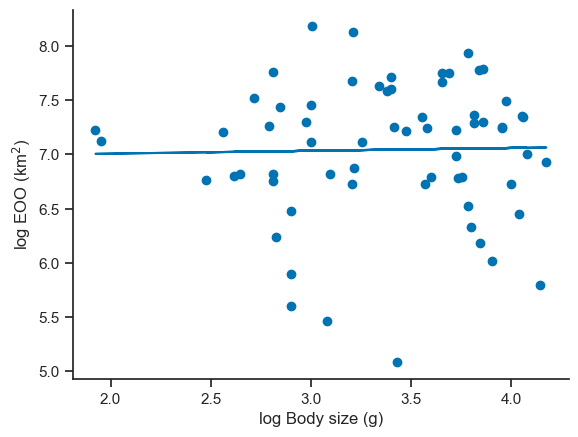

In [ ]:
# Fit a polynomial with least squares polynomial fit
a, b = np.polyfit(
    x=scavengers["log Body size"], y=scavengers["log Extent of occurrence"], deg=1,
)

plt.scatter(
    y=scavengers["log Extent of occurrence"], x=scavengers["log Body size"],
) #  color="blue"
plt.plot(scavengers["log Body size"], a * scavengers["log Body size"] + b)

plt.xlabel("log Body size (g)")
plt.ylabel("log EOO (km$^2$)")

# plt.text(1, 90, "y = " + "{:.3f}".format(b) + " + {:.3f}".format(a) + "x", size=12)

## GLM comparison

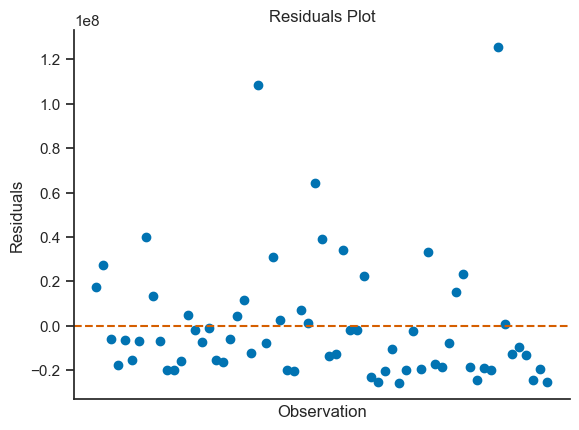

In [20]:
glm_model = sm.GLM(y, x, family=sm.families.Gaussian()).fit()
glm_residuals = glm_model.resid_response

plt.plot(glm_residuals, "o")
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks([])
plt.xlabel("Observation")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()


It still does not look great, *but* it is better than a flat line. We still cannot conclude whether this GLM is a better approach than the above OLS, so let's examine the residuals.

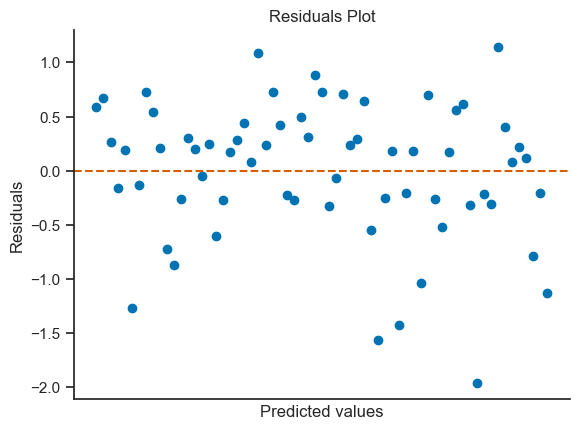

In [ ]:
glm_residuals = glm_model.resid_response

plt.plot(glm_residuals, "o")
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks([])
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

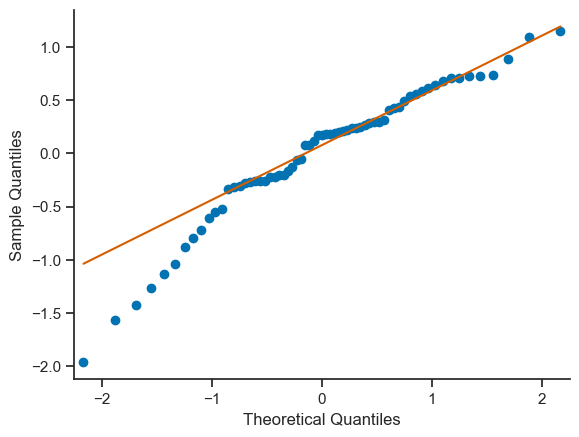

In [ ]:
sm.qqplot(glm_residuals, line="q")
plt.show()

In [ ]:
# Redefine the X and Y matrices with non-transformed data
y = scavengers["Extent of occurrence"]
x = scavengers["Body size"]
x = sm.add_constant(x)

glm_model = sm.GLM(
    y, x, family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

print(glm_model.summary())
print({f"AIC": glm_model.aic})

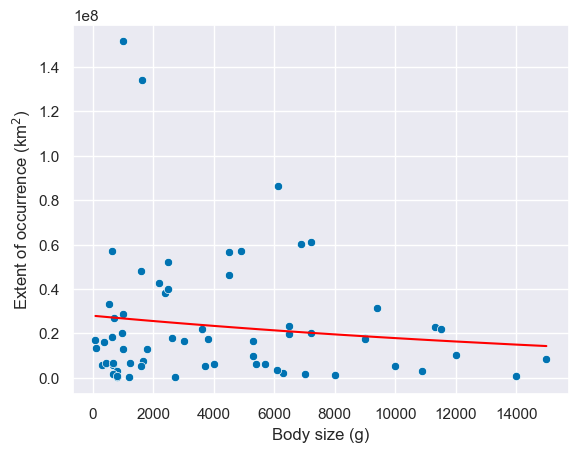

In [ ]:
scavengers["glm_predicted"] = glm_model.predict(x)

sns.scatterplot(
    x=scavengers["Body size"],
    y=scavengers["Extent of occurrence"],
)
sns.lineplot(
    x=scavengers["Body size"],
    y=scavengers["glm_predicted"],
    color="red",
)
plt.xlabel("Body size (g)")
plt.ylabel("Extent of occurrence (km$^2$)")
plt.show()

# Obligate and facultative scavengers

Now we want to  include an interaction term in our regression, separating avian scavengers into obligate and facultative scavengers to see if examining these birds at this functional level will reveal a difference in the relationship between body size and range size . The interaction term will allow our groups to have their own intercepts.

We have two predictor variables, $x_1$ and $x_2$, for body size and diet. The first is quantitative continuous data, and the latter is categorical, "facultative" and "obligate", which we can have Python convert into numerical values by arbitrarily assigning one to be our baseline group, 0, and the other 1. Adding an interaction term will make the linear equation look like:

$$
    y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_{12}x_1x_2 + \epsilon
$$

Since one category in $x_2$ is a zero, this will allow us to calculate the best fit line 

<!-- where $\beta_{12}x_1x_2$ can be simplified to $\beta_3x_3$. -->

In [ ]:
import patsy 

logEOO = np.log10(scavengers["Extent of occurrence"])
logBodySize = np.log10(scavengers["Body size"])

# Make the design matrices with Patsy
y, X = patsy.dmatrices('logEOO ~ logBodySize * Diet', data=scavengers, return_type='dataframe')

dummy_interaction_OLS = sm.OLS(y, X).fit()
print(dummy_interaction_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 logEOO   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7522
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.525
Time:                        14:35:53   Log-Likelihood:                -61.086
No. Observations:                  65   AIC:                             130.2
Df Residuals:                      61   BIC:                             138.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
logEOO = np.log10(scavengers["Extent of occurrence"])
logBodySize = np.log10(scavengers["Body size"])

# Make the design matrices with Patsy
y, X = patsy.dmatrices('logEOO ~ logBodySize * Diet', data=scavengers, return_type='dataframe')

dummy_interaction_OLS = sm.OLS(y, X).fit()
print(dummy_interaction_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 logEOO   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7522
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.525
Time:                        13:34:58   Log-Likelihood:                -61.086
No. Observations:                  65   AIC:                             130.2
Df Residuals:                      61   BIC:                             138.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [ ]:
# Create new columns with spaceless names. I prefer camel case for screen reader reasons.
scavengers["logExtentOfOccurrence"] = scavengers["log Extent of occurrence"]
scavengers["logBodySize"] = scavengers["log Body size"]

formula = "logExtentOfOccurrence ~ logBodySize + Diet + logBodySize:Diet"

print(smf.ols(formula=formula, data=scavengers).fit().summary())

                              OLS Regression Results                             
Dep. Variable:     logExtentOfOccurrence   R-squared:                       0.036
Model:                               OLS   Adj. R-squared:                 -0.012
Method:                    Least Squares   F-statistic:                    0.7522
Date:                   Fri, 25 Apr 2025   Prob (F-statistic):              0.525
Time:                           12:50:01   Log-Likelihood:                -61.086
No. Observations:                     65   AIC:                             130.2
Df Residuals:                         61   BIC:                             138.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
formula = "ExtentOfOccurrence ~ BodySize + Diet + BodySize:Diet"

interaction_ols = smf.glm(
    formula=formula,
    data=scavengers,
    family=sm.families.InverseGaussian(link=sm.families.links.Log()),
).fit()
print(interaction_ols.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     ExtentOfOccurrence   No. Observations:                   65
Model:                            GLM   Df Residuals:                       61
Model Family:         InverseGaussian   Df Model:                            3
Link Function:                    Log   Scale:                      6.3159e-08
Method:                          IRLS   Log-Likelihood:                -1273.9
Date:                Fri, 25 Apr 2025   Deviance:                   2.1684e-05
Time:                        14:29:25   Pearson chi2:                 3.85e-06
No. Iterations:                    28   Pseudo R-squ. (CS):            0.04427
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
# Extract coefficients from the model
intercept = dummy_interaction_OLS.params["Intercept"]
diet_obligate_coef = dummy_interaction_OLS.params["Diet[T.Obligate]"]
log_body_coef = dummy_interaction_OLS.params["logBodySize"]
interaction_coef = dummy_interaction_OLS.params["logBodySize:Diet[T.Obligate]"]

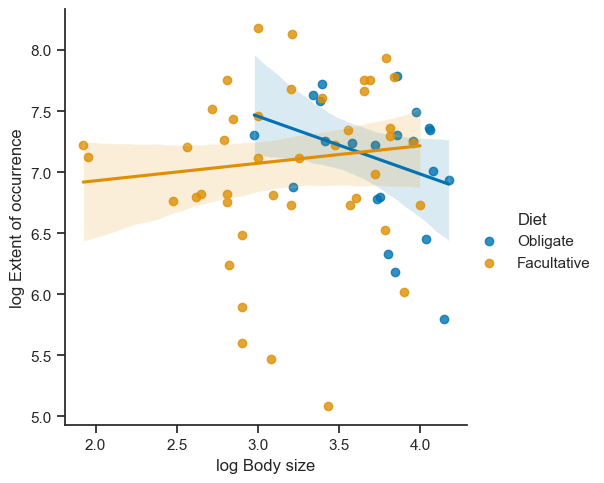

In [39]:
sns.lmplot(
    x="log Body size",
    y="log Extent of occurrence",
    data=scavengers,
    hue="Diet",
    scatter=True,
    robust=True,  # De-weights outliers
)
plt.show()

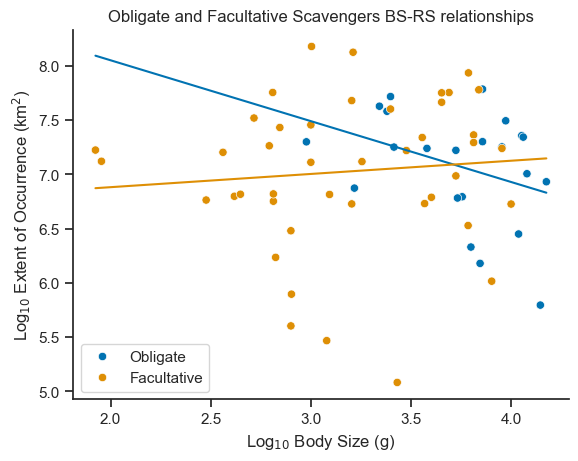

In [ ]:
log_body_values = np.linspace(
    scavengers["log Body size"].min(),
    scavengers["log Body size"].max(),
    100,
)

# Calculate regression lines for obligate and facultative scavengers
log_eoo_obligate = (
    intercept
    + log_body_coef * log_body_values
    + diet_obligate_coef
    + interaction_coef * log_body_values
)
log_eoo_facultative = intercept + log_body_coef * log_body_values

# Create a scatter plot with regression lines for obligate and facultative scavengers
sns.scatterplot(
    data=scavengers,
    x="log Body size",
    y="log Extent of occurrence",
    hue="Diet",
)

# Plot regression lines
plt.plot(log_body_values, log_eoo_obligate)
plt.plot(log_body_values, log_eoo_facultative)

plt.xlabel("Log$_{10}$ Body Size (g)")
plt.ylabel("Log$_{10}$ Extent of Occurrence (km$^2$)")
plt.legend()
plt.title("Obligate and Facultative Scavengers BS-RS relationships")

plt.show()

In [ ]:
# Assign new columns with syntactically compatible names. 
scavengers['logExtentOfOccurrence'] = scavengers['log Extent of occurrence']
scavengers['logBodySize'] = scavengers['log Body size']

interaction_ols = smf.ols(
    formula="logExtentOfOccurrence ~ logBodySize * Diet",
    data=scavengers,
).fit()
print(interaction_ols.summary())

                              OLS Regression Results                             
Dep. Variable:     logExtentOfOccurrence   R-squared:                       0.036
Model:                               OLS   Adj. R-squared:                 -0.012
Method:                    Least Squares   F-statistic:                    0.7522
Date:                   Wed, 16 Apr 2025   Prob (F-statistic):              0.525
Time:                           14:36:01   Log-Likelihood:                -61.086
No. Observations:                     65   AIC:                             130.2
Df Residuals:                         61   BIC:                             138.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
interaction_shapiro = stats.shapiro(interaction_residuals)

print(
    f"Diet interaction Shapiro-Wilk test:\n"
    f"Statistic: {interaction_shapiro.statistic:.2f}, p-value: {interaction_shapiro.pvalue:.5f}"
)

Diet interaction Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.01722


In [ ]:
obligates_shapiro = stats.shapiro(obligates_model.resid_response)

print(
    f"Obligates GLM residuals Shapiro-Wilk test:\n"
    f"Statistic: {obligates_shapiro.statistic:.2f}, p-value: {obligates_shapiro.pvalue:.5f}"
)

Obligates GLM residuals Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.30664


The residuals for this model are normally distributed, so I won't worry about a non-parametric test for this .

<a id='4.2.4'></a>
### 4.2.4 Non-parametric test: Spearman's correlation coefficient

Since the `GLM` with the Diet interaction term was not normally distributed
I will need to do a Spearman's coefficient test for scavengers grouped according to diet a little differently to take that interaction term into consideration. I'm no stranger to empty lists or dictionaries, but adjusting the `spearmanr` function to work in a for loop was tough so I brought in Copilot again to help troubleshoot.

In [ ]:
# Set aside the diet groups to run in a for loop
diet_categories = scavengers["Diet"].unique()

# Make an empty dictionary
results = {}
# And write the results into the empty dictionary from the for loop
for diet in diet_categories:
    subset = scavengers[scavengers["Diet"] == diet]
    log_body = subset["log Body size"]
    log_eoo = subset["log Extent of occurrence"]
    correlation, p_value = stats.spearmanr(log_body, log_eoo)
    results[diet] = {"correlation": correlation, "p_value": p_value}

for diet, result in results.items():
    print(f"Diet: {diet}")
    print(f"Spearman correlation coefficient: {result['correlation']}")
    print(f"P-value: {result['p_value']}\n")

Diet: Obligate
Spearman correlation coefficient: -0.23948038232571622
P-value: 0.2830859198555416

Diet: Facultative
Spearman correlation coefficient: 0.1268786378007815
P-value: 0.41749970485993904



Q-Q and histogram plots

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")

# # Make the Q-Q plot
# stats.probplot(gaussian_residuals, plot=axes[0])
# axes[0].set_title("Q-Q Plot of Residuals")

# # Make the histogram
# axes[1].hist(gaussian_residuals, bins=20, edgecolor="k")
# axes[1].set_title("Histogram of Residuals")
# axes[1].set_xlabel("Residuals")
# axes[1].set_ylabel("Frequency")

# plt.suptitle("All residuals, not distinguished by Diet")
# plt.show()

This model seems to fit moderately well. The residuals are fairly evenly distributed in the residuals plot, and I'm not seeing clusters of data.
The Q-Q plot also seems to fit better and the values don't stray terribly far from the quartiles line.
I won't worry about those lower values based on the outliers exploration from Section 4.1.3, nor about doing a robust linear model `RLM`.